In [1]:
############# Reading the data 

In [2]:
import numpy as np 
#loaded_discharge = np.load('/ec/res4/hpcperm/ecmv6565/forecast_analysis/discharge_array.npy')
loaded_stations = np.load('/ec/res4/hpcperm/ecmv6565/forecast_analysis/station_dict.npy', allow_pickle=True).item() # dictionary that matches the array index with the station ID 

In [3]:
import pickle

# Load the dictionary from a file
with open("/ec/res4/hpcperm/ecmv6565/forecast_analysis/metrics_calculated_slurm.pkl", "rb") as f: ## reading the deterministic metrics 
    metrics_dict = pickle.load(f)

# Example: Accessing data
# Print metirc for lead time 0, ensemble 0, first station
metric= 'KGE'
lead_time = 0
ensemble = 0
station = 10
 
metric_value = metrics_dict[metric][lead_time][ensemble][station]
print(f"{metric} for lead time {lead_time}, ensemble {ensemble}, station {station}: {metric_value}")


KGE for lead time 0, ensemble 0, station 10: 0.586536683813514


In [4]:
######## visualizing the KGE and its components 

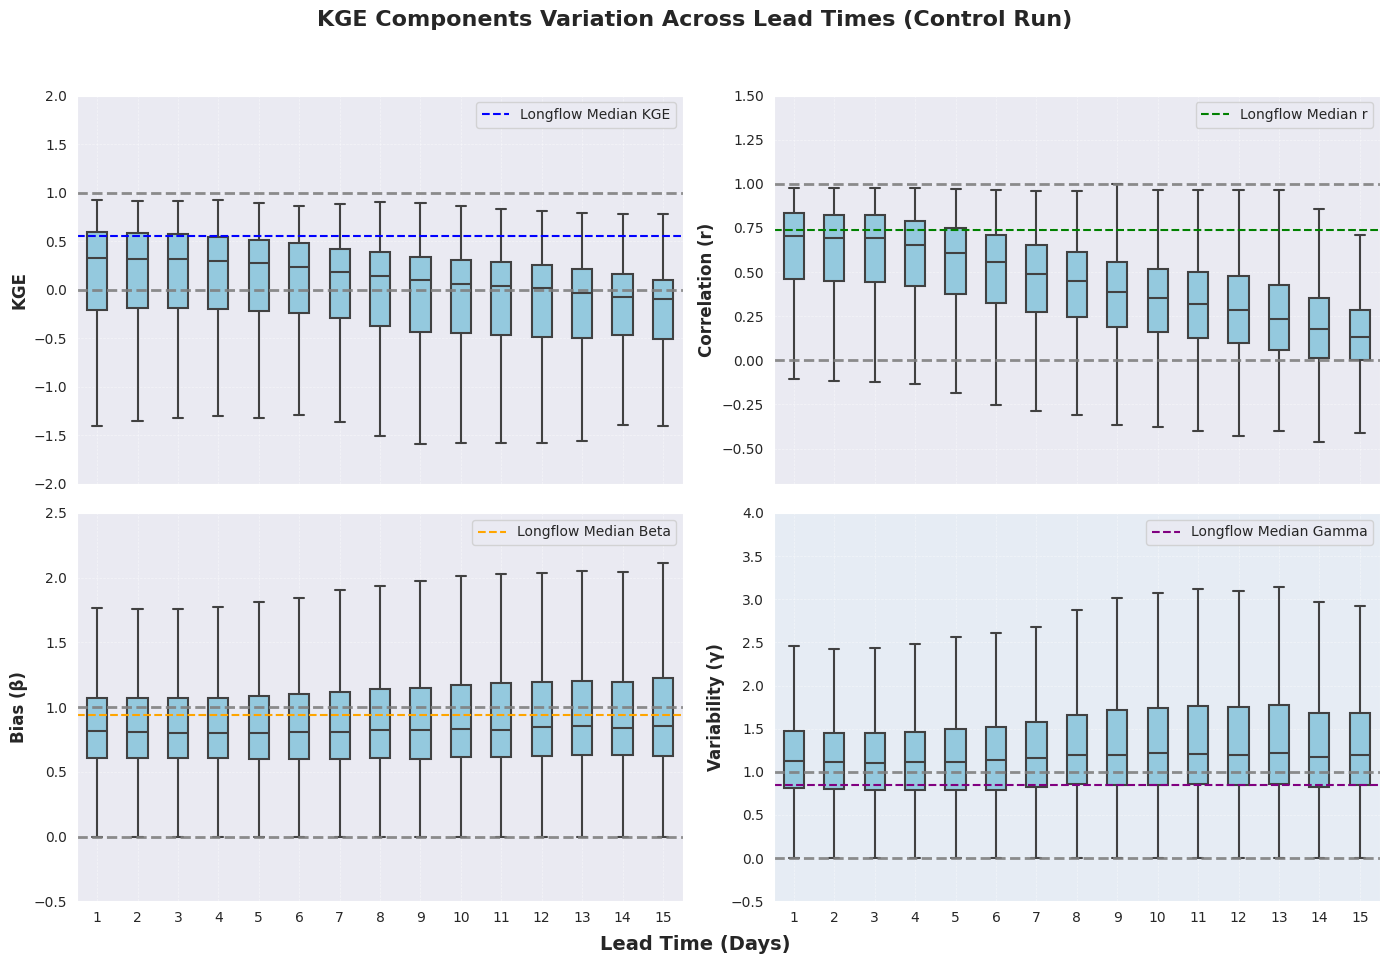

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_multiple_metrics(kge_dict, metrics, csv_path):
    """
    Plots multiple chosen metrics across selected lead times and shows the variation across stations using boxen plots.

    Parameters:
        kge_dict (dict): Dictionary containing the metric values.
        metrics (list): List of metrics to plot (e.g., ['KGE', 'r', 'Beta', 'Gamma']).
        csv_path (str): Path to the CSV file containing reference median values.
    """
    # Load long flow metric values from CSV and compute the median across stations
    df = pd.read_csv(csv_path)
    median_values = {metric: df[metric].median() for metric in metrics}

    # Define lead times in days (each day = 4 hourly time steps)
    selected_days = list(range(1, 16))
    selected_time_steps = [(day * 4 - 1) for day in selected_days]  # Convert to hourly lead times

    # Extract stations and set ensemble index
    ensemble = 0  # Fixed ensemble for consistency
    stations = range(len(kge_dict[metrics[0]][0][0]))  # Assuming stations are indexed sequentially

    # Create subplots (2 rows, 2 columns)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)  # sharex=True ensures a single x-axis label
    axes = axes.flatten()  # Flatten for easier iteration

    # Define y-axis limits for each metric
    y_limits = {
        "KGE": (-2, 2),  # KGE typically ranges between -1 and 1
        "r": (-0.7, 1.5),     # Correlation (r) ranges between 0 and 1
        "Beta": (-0.5, 2.5),  # Bias (Beta) typically ranges between 0 and 2
        "Gamma": (-0.5, 4)  # Variability (Gamma) typically ranges between 0 and 2
    }

    # Define labels for each metric
    metric_labels = {
        "KGE": "KGE",
        "r": "Correlation (r)",
        "Beta": "Bias (β)",
        "Gamma": "Variability (γ)"
    }

    colors = ["blue", "green", "orange", "purple"]  # Colors for median reference lines

 #   sns.set_style("whitegrid")  # Mimics ggplot2 default theme

    for i, metric in enumerate(metrics):
        # Extract metric values for the selected lead times
        metric_values = np.array([
            [kge_dict[metric][lead_time][ensemble][station] for station in stations] 
            for lead_time in selected_time_steps
        ])

        # --- R-style Boxen Plot ---
        sns.set_style("darkgrid")  # Darker grid to match requested style
        background_color = "#E6ECF4"  # Light blue/grayish background for distinct plot area

        ax = plt.gca()
        ax.set_facecolor(background_color)

        sns.boxplot(
            data=metric_values.T, 
            ax=axes[i], 
            width=0.5, 
            showfliers=False ,  # Removed outliers
            color="skyblue",  # Box color
            linewidth=1.5,  # Adjust line thickness
        )

        # Set x-ticks to display selected days
        axes[i].set_xticks(range(len(selected_days)))
        axes[i].set_xticklabels(selected_days, fontsize=10)

        # Set y-axis limits for the current metric
        axes[i].set_ylim(y_limits[metric])

        # Labels & Title
        axes[i].set_ylabel(metric_labels[metric], fontsize=12, fontweight="bold")

        # Add median reference line
        axes[i].axhline(y=median_values[metric], color=colors[i], linestyle="--", linewidth=1.5, label=f"Longflow Median {metric}")

        # Highlight 0 and 1 with grid lines (no legend entry)
        axes[i].axhline(y=0, color="gray", linestyle="--", linewidth=2, alpha=0.9)  # Subtle line at 0
        axes[i].axhline(y=1, color="gray", linestyle="--", linewidth=2, alpha=0.9)  # Subtle line at 1
        axes[i].legend()

        # Apply a subtle background grid
        axes[i].grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

    # Universal x-axis label
    fig.text(0.5, 0.04, "Lead Time (Days)", ha="center", fontsize=14, fontweight="bold")

    # Universal title
    fig.suptitle("KGE Components Variation Across Lead Times (Control Run)", fontsize=16, fontweight="bold")

    # Adjust layout for better appearance
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to fit title and x-label
    
    plt.show()

# File path to the CSV
csv_path = "/ec/res4/hpcperm/ecmv6565/timeseries_stations/statistics_calibrated_p3.csv"

# Example usage
metrics_to_plot = ["KGE", "r", "Beta", "Gamma"]
plot_multiple_metrics(metrics_dict, metrics_to_plot, csv_path)

In [6]:
####### Visualizing metrics spatially 

/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.64355474/ipykernel_1821481/864423285.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


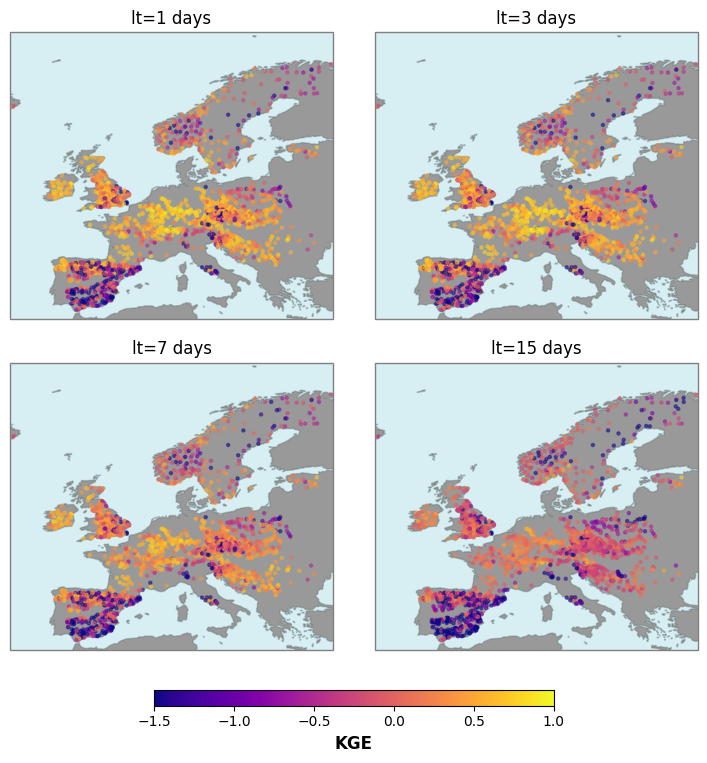

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

sns.reset_orig()

def plot_metric_spatial_multiple_lead_times(metrics_dict, metric, station_info, lead_times, loaded_stations, filename):
    """
    Plots the specified metric from the control ensemble (ensemble 0) for all stations for multiple lead times.

    Parameters:
        metrics_dict (dict): Dictionary containing metrics (metric -> lead time -> ensemble -> station -> metric value).
        metric (str): The metric to plot (e.g., 'KGE').
        station_info (pd.DataFrame): DataFrame containing station metadata.
        lead_times (list): List of lead times for which the metric is plotted.
        loaded_stations (dict): Mapping of station indices to station IDs.
        filename (str): File name to save the plot.
    """
    # Initialize the figure
    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    # Define a bright colormap (e.g., 'viridis', 'plasma', 'inferno', 'magma')
    colormap = plt.get_cmap('plasma')  # You can choose any colormap you like

    # Define the color range
    vmin, vmax = -1.5, 1  # Limit the color range between -4 and 1

    for i, lead_time in enumerate(lead_times):
        ax = axes[i]
        ax.set_extent([-15, 30, 35, 75], crs=ccrs.PlateCarree())  # Europe-focused map

        # Add map features
        ax.add_feature(cfeature.LAND, edgecolor='gray', facecolor='gray', alpha=0.8)  # Land with gray fill
        ax.add_feature(cfeature.OCEAN, facecolor="#B0E0E6", alpha=0.5)  # Ocean with light blue fill

        # Add gray border around each subplot
        for spine in ax.spines.values():
            spine.set_edgecolor('gray')  # Set border color to gray
            spine.set_linewidth(1)     # Set border width

        # Extract metric values for the specified lead time and control ensemble (ensemble 0)
        station_ids = []
        metric_values = []

        if metric in metrics_dict and lead_time in metrics_dict[metric] and 0 in metrics_dict[metric][lead_time]:
            for station_idx, station_id in loaded_stations.items():
                if station_idx < len(metrics_dict[metric][lead_time][0]):  # Ensure index is valid
                    metric_value = metrics_dict[metric][lead_time][0][station_idx]
                    
                    if not np.isnan(metric_value):  # Ignore NaN values
                        station_ids.append(station_id)
                        metric_values.append(metric_value)

        # Create a DataFrame with the extracted data
        metric_df = pd.DataFrame({'station_id': station_ids, 'metric': metric_values})
        
        # Convert station_id to string for merging
        metric_df['station_id'] = metric_df['station_id'].astype(str)
        station_info['ObsID'] = station_info['ObsID'].astype(str)

        # Merge with station metadata
        merged_data = pd.merge(metric_df, station_info, how='left', left_on='station_id', right_on='ObsID')

        # Remove invalid metric values
        merged_data = merged_data.dropna(subset=['metric'])
        merged_data = merged_data[merged_data['metric'] >= -50]  # Remove extreme negative values

        # Clip metric values to the range [-4, 1]
        merged_data['metric'] = merged_data['metric'].clip(lower=vmin, upper=vmax)

        # Normalize metric values for colormap
        norm = Normalize(vmin=vmin, vmax=vmax)

        # Plot metric values with continuous color range
        scatter = ax.scatter(
            merged_data['StationLon'], merged_data['StationLat'],
            c=merged_data['metric'], cmap=colormap, norm=norm, alpha=0.5, s=5  # Subtle markers
        )

        ax.set_title(f'lt={int((lead_time + 1) / 4)} days', fontsize=12)

    # Add a shared colorbar at the bottom
    cbar_ax = fig.add_axes([0.25, 0.13, 0.5, 0.02])  # Position of the colorbar
    sm = ScalarMappable(norm=norm, cmap=colormap)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(metric, fontsize=12, fontweight='bold')

    # Adjust layout and save
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2, wspace=-0.1, hspace=0.15)  # Adjust spacing
    plt.savefig(filename, bbox_inches='tight', dpi=300)  # High resolution for publication
    plt.show()

# Example usage
station_info = pd.read_csv('/home/ecmv6565/Downloads/outlets_updated.csv')  # Load station metadata
lead_times = [3, 11, 27, 59]  # Choose desired lead times
metric_to_plot = 'KGE'
plot_metric_spatial_multiple_lead_times(metrics_dict, metric_to_plot, station_info, lead_times, loaded_stations, 'metric_map_multiple_lead_times.png')

In [ ]:
###### CDF plots for different lead times 

/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.64154677/ipykernel_2858377/3379184451.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


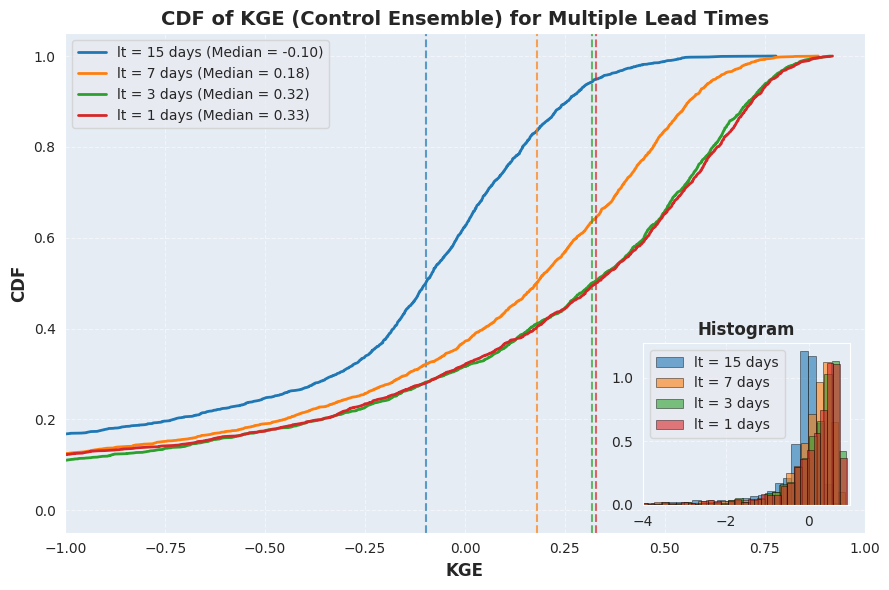

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_cdf_control_ensemble(metrics_dict, metric, lead_times, loaded_stations, filename):
    """
    Plots the CDF of a specified metric for multiple lead times using only the control ensemble (ensemble 0),
    on the same graph, and adds a histogram for each lead time.

    Parameters:
        metrics_dict (dict): Dictionary containing different metrics (metric -> lead_time -> ensemble -> station).
        metric (str): The metric to plot (e.g., "KGE", "NSE", "RMSE").
        lead_times (list): List of lead times to plot.
        loaded_stations (dict): Mapping of station indices to station IDs.
        filename (str): Filename to save the plot.
    """
    if metric not in metrics_dict:
        print(f"Error: Metric '{metric}' not found in metrics_dict.")
        return

    # Set style and background color
    sns.set_style("darkgrid")  # Darker grid to match requested style
    background_color = "#E6ECF4"  # Light blue/grayish background for distinct plot area

    fig, ax_cdf = plt.subplots(figsize=(9, 6))
    ax_cdf.set_facecolor(background_color)  # Set background color for CDF plot

    # Define nice matching colors for CDF and histograms
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

    all_metric_values = {lead_time: [] for lead_time in lead_times}

    # Sort lead times in ascending order to plot smallest lead times last (on top)
    sorted_lead_times = sorted(lead_times, reverse=True)

    for idx, lead_time in enumerate(sorted_lead_times):
        if lead_time not in metrics_dict[metric] or 0 not in metrics_dict[metric][lead_time]:  
            print(f"Lead time {lead_time} not found in metrics_dict[{metric}]. Skipping.")
            continue

        # Extract values for the selected metric and lead time
        metric_values = [
            metrics_dict[metric][lead_time][0][station_idx]
            for station_idx in loaded_stations
            if station_idx in metrics_dict[metric][lead_time][0] and not np.isnan(metrics_dict[metric][lead_time][0][station_idx])
        ]

        # Filter out extreme negative values (if applicable)
        metric_values = [value for value in metric_values if value >= -50]

        # Sort data for CDF
        sorted_values = np.sort(metric_values)
        y_values = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
        median_value = np.median(sorted_values) if len(sorted_values) > 0 else np.nan

        # Plot CDF
        ax_cdf.plot(
            sorted_values, y_values,
            label=f'lt = {int((lead_time + 1) / 4)} days (Median = {median_value:.2f})',
            color=colors[idx % len(colors)], linewidth=2
        )
        ax_cdf.axvline(
            x=median_value, color=colors[idx % len(colors)],
            linestyle='--', alpha=0.7, linewidth=1.5
        )

        # Collect metric values for histogram
        all_metric_values[lead_time] = metric_values

    # Set CDF plot attributes
    ax_cdf.set_xlim(-1, 1)  # Adjust x-axis limits for KGE
    ax_cdf.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax_cdf.set_ylabel('CDF', fontsize=12, fontweight='bold')
    ax_cdf.set_title(f'CDF of {metric} (Control Ensemble) for Multiple Lead Times', fontsize=14, fontweight='bold')
    ax_cdf.legend(loc='upper left', framealpha=0.7)
    ax_cdf.grid(True, linestyle='--', alpha=0.5)

    # Add the histogram as a subplot
    ax_hist = fig.add_axes([0.72, 0.15, 0.23, 0.27])  # [left, bottom, width, height]
    ax_hist.set_facecolor(background_color)  # Set background color for histogram

    # Plot histograms in reverse order to ensure smallest lead times are on top
    for idx, lead_time in enumerate(sorted_lead_times):
        metric_values = all_metric_values[lead_time]

        # Set transparency based on lead time: lower lead times have higher visibility
        alpha_value = 0.6  

        ax_hist.hist(
            metric_values, bins=250, alpha=alpha_value,
            color=colors[idx % len(colors)],
            label=f'lt = {int((lead_time + 1) / 4)} days', density=True,
            edgecolor='black', linewidth=0.5  # Add black edges for contrast
        )

    # Set histogram labels and limits
    ax_hist.set_xlim(-4, 1)  # Adjust x-axis limits for KGE
    ax_hist.set_title('Histogram', fontsize=12, fontweight='bold')
    ax_hist.legend(framealpha=0.7)
    ax_hist.grid(True, linestyle='--', alpha=0.5)

    # Remove x and y labels from the histogram
    ax_hist.set_xlabel('')
    ax_hist.set_ylabel('')

    # Save and show the plot
    plt.tight_layout()
    #plt.savefig(filename, bbox_inches='tight', dpi=300)  # High resolution for publication
    plt.show()
   # print(f"Plot saved as {filename}")

# Example usage
lead_times = [3, 11, 27, 59]  # Lead times to plot
metric_to_plot = 'KGE'
plot_metric_cdf_control_ensemble(metrics_dict, metric_to_plot, lead_times, loaded_stations, 'kge_cdf_control_ensemble.png')

In [ ]:
########## Probablistic metics (CRPS, CRPS_persitence, CRPSS)

In [9]:
import pickle

# Load the dictionary from a file
with open("/ec/res4/hpcperm/ecmv6565/forecast_analysis/crps_results.pkl", "rb") as f:  ######## reading the CRPS results
    crps_dict = pickle.load(f)

# Example: Accessing data
# Print metirc for lead time 0, ensemble 0, first station
metric= 'KGE'
lead_time = 0
ensemble = 0
station = 100

metric_value = crps_dict[lead_time][station]
print(metric_value)



31.766782800439294


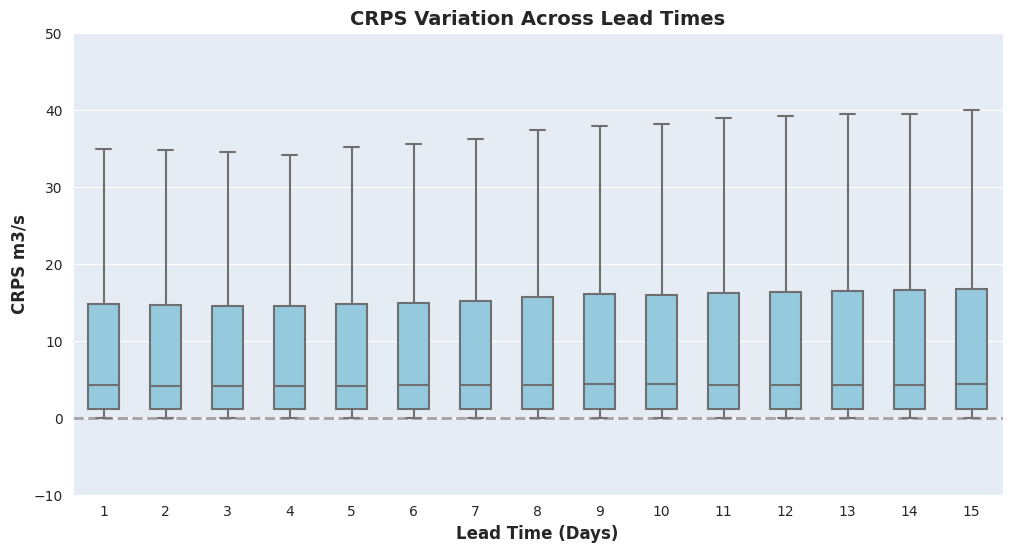

In [13]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the CRPS results
crps_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis/crps_results.pkl"
with open(crps_path, "rb") as f:
    crps_dict = pickle.load(f)

# Convert CRPS results into a NumPy array for easy visualization
num_lead_times = len(crps_dict)
num_stations = len(next(iter(crps_dict.values())))  # Get number of stations from first lead time

# Store CRPS values in an array (lead_times × stations)
crps_array = np.full((num_lead_times, num_stations), np.nan)



for lead_time, station_values in crps_dict.items():
    for station, crps_value in station_values.items():
        crps_array[lead_time, station] = crps_value

# Define selected lead times in days (each day = 4 hourly time steps)
selected_days = list(range(1, 16))
selected_time_steps = [(day * 4 - 1) for day in selected_days]  # Convert to hourly lead times

# Convert the CRPS data into a pandas DataFrame for Seaborn compatibility
data = []
for lead_time, day in zip(selected_time_steps, selected_days):
    for station in range(num_stations):
        data.append([day, crps_array[lead_time, station], station + 1])

df = pd.DataFrame(data, columns=['Lead Time (Days)', 'CRPS', 'Station'])

# --- Boxen Plot Style Matching the Given Image ---
sns.set_style("darkgrid")  # Darker grid style
background_color = "#E6ECF4"  # Light blue-gray background

plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_facecolor(background_color)  # Set background color

# Boxen Plot with Matching Colors
sns.boxplot(
    x="Lead Time (Days)", y="CRPS", data=df, 
    width=0.5, showfliers=False,  # Keeping outliers to match style
    color="skyblue",  # Same blue color as the reference image
    linewidth=1.5
)

# Title and Labels
plt.title("CRPS Variation Across Lead Times", fontsize=14, fontweight="bold")
plt.xlabel("Lead Time (Days)", fontsize=12, fontweight="bold")
plt.ylabel("CRPS m3/s", fontsize=12, fontweight="bold")

# Axis Limits
plt.ylim(-10, 50)

# Add Key Reference Lines (Matching the KGE Plot)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=2, alpha=0.7)  # Subtle line at 0 # Black dashed line at 0

# Adjust Tick Labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show Final Figure
plt.show()


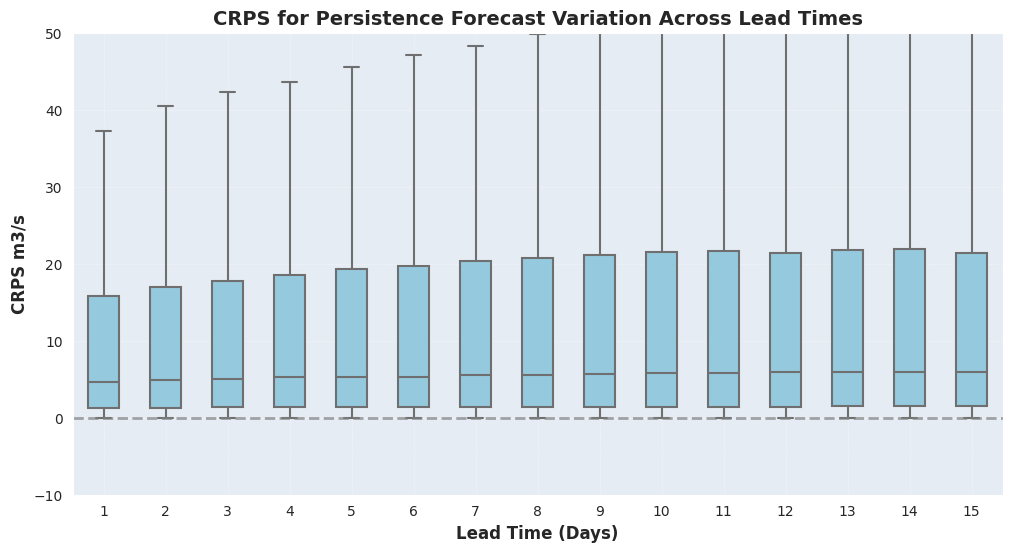

In [12]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the CRPS results
#crps_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis/crps_persistence_results.pkl"
crps_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis/crps_persistence_results.pkl"
with open(crps_path, "rb") as f:
    crps_dict = pickle.load(f)

# Convert CRPS results into a NumPy array for easy visualization
num_lead_times = len(crps_dict)
num_stations = len(next(iter(crps_dict.values())))  # Get number of stations from first lead time

# Store CRPS values in an array (lead_times × stations)
crps_array = np.full((num_lead_times, num_stations), np.nan)

for lead_time, station_values in crps_dict.items():
    for station, crps_value in station_values.items():
        crps_array[lead_time, station] = crps_value

# Define selected lead times in days (each day = 4 hourly time steps)
selected_days = list(range(1, 16))
selected_time_steps = [(day * 4 - 1) for day in selected_days]  # Convert to hourly lead times

# Convert the CRPS data into a pandas DataFrame for Seaborn compatibility
data = []
for lead_time, day in zip(selected_time_steps, selected_days):
    for station in range(num_stations):
        data.append([day, crps_array[lead_time, station], station + 1])

df = pd.DataFrame(data, columns=['Lead Time (Days)', 'CRPS', 'Station'])

# --- R-style Visualization ---

sns.set_style("darkgrid")  # Darker grid to match requested style
background_color = "#E6ECF4"  # Light blue/grayish background for distinct plot area
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_facecolor(background_color)


sns.boxplot(
    x="Lead Time (Days)", y="CRPS", data=df, 
    width=0.5, showfliers=False,  # Keeping outliers to match style
    color="skyblue",  # Same blue color as the reference image
    linewidth=1.5,
   
)
# Format plot for a scientific appearance
plt.title("CRPS for Persistence Forecast Variation Across Lead Times", fontsize=14, fontweight="bold")
plt.xlabel("Lead Time (Days)", fontsize=12, fontweight="bold")
plt.ylabel("CRPS m3/s", fontsize=12, fontweight="bold")
plt.ylim(-10, 50)

# Subtle grid with R-style look
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=2, alpha=0.7)  # Subtle line at 0  # Subtle line at 0

# Adjust tick labels for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show final figure
plt.show()


In [18]:
# CRPSS vs the persistence forecast 

61.36898581647521

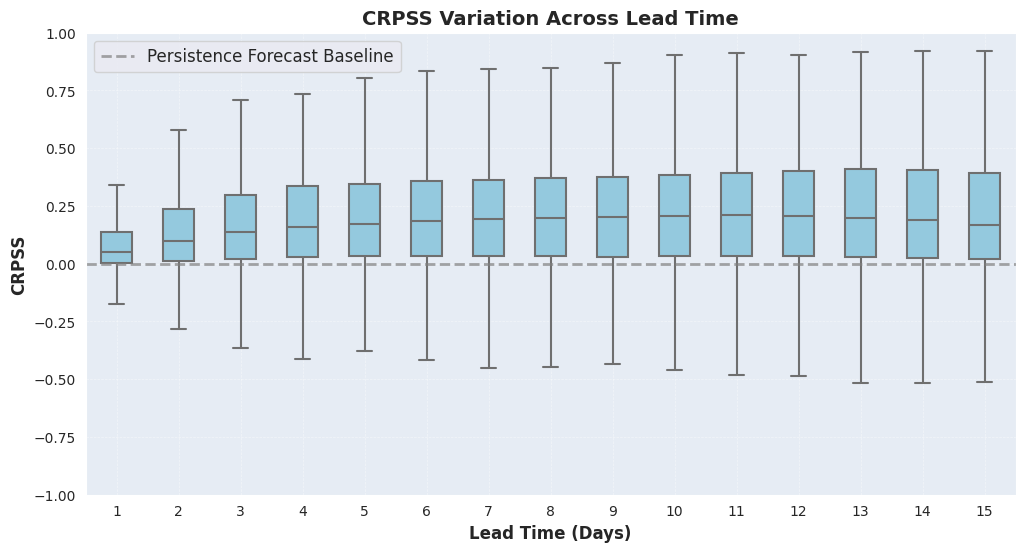

In [12]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CRPS results
crps_forecast_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis/crps_results.pkl"
crps_persistence_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis/crps_persistence_results.pkl"

with open(crps_forecast_path, "rb") as f:
    crps_forecast_dict = pickle.load(f)

with open(crps_persistence_path, "rb") as f:
    crps_persistence_dict = pickle.load(f)

# Compute CRPSS
crpss_dict = {}

for lead_time in crps_forecast_dict.keys():
    crpss_dict[lead_time] = {}
    for station in crps_forecast_dict[lead_time].keys():
        crps_forecast = crps_forecast_dict[lead_time].get(station, np.nan)
        crps_persistence = crps_persistence_dict[lead_time].get(station, np.nan)
        
        # Avoid division by zero and ensure meaningful CRPSS
        if not np.isnan(crps_forecast) and not np.isnan(crps_persistence) and crps_persistence > 0:
            crpss_dict[lead_time][station] = 1 - (crps_forecast / crps_persistence)
        else:
            crpss_dict[lead_time][station] = np.nan

# Define selected lead times in days (each day = 4 hourly time steps)
selected_days = [x for x in range(1, 16)]
selected_time_steps = [(day * 4 - 1) for day in selected_days]  # Convert to hourly lead times

# Convert CRPSS dictionary to DataFrame
crpss_data = []
for lead_time, day in zip(selected_time_steps, selected_days):
    for station, crpss_value in crpss_dict.get(lead_time, {}).items():
        if not np.isnan(crpss_value):  # Ignore NaN values
            crpss_data.append([day, station, crpss_value])

df_crpss = pd.DataFrame(crpss_data, columns=["Lead Time (Days)", "Station", "CRPSS"])

# --- Boxen Plot Style Matching the Given Image ---
sns.set_style("darkgrid")  # Darker grid style
background_color = "#E6ECF4"  # Light blue-gray background

plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_facecolor(background_color)  # Set background color

# Boxen Plot with Matching Colors
sns.boxplot(
    data=df_crpss, x="Lead Time (Days)", y="CRPSS",
    width=0.5, showfliers=False,  # Keeping outliers to match style
    color = "skyblue",
    #boxprops={"facecolor": "#1F77B4", "edgecolor": "black"},  # White box with black edges# Same blue color as the reference image
    linewidth=1.5
)

# Title and Labels
plt.title("CRPSS Variation Across Lead Time", fontsize=14, fontweight="bold")
plt.xlabel("Lead Time (Days)", fontsize=12, fontweight="bold")
plt.ylabel("CRPSS", fontsize=12, fontweight="bold")

# Axis Limits
plt.ylim(-1, 1)

# Add Key Reference Lines (Matching the KGE Plot)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=2, alpha= 0.7, label="Persistence Forecast Baseline")


# Adjust Tick Labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

plt.legend(fontsize=12)

# Show Final Figure
plt.show()


## Backup scripts 

/etc/ecmwf/ssd/ssd1/jupyterhub/ecmv6565-jupyterhub/tmpdirs/ecmv6565.63871352/ipykernel_2019534/445344557.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


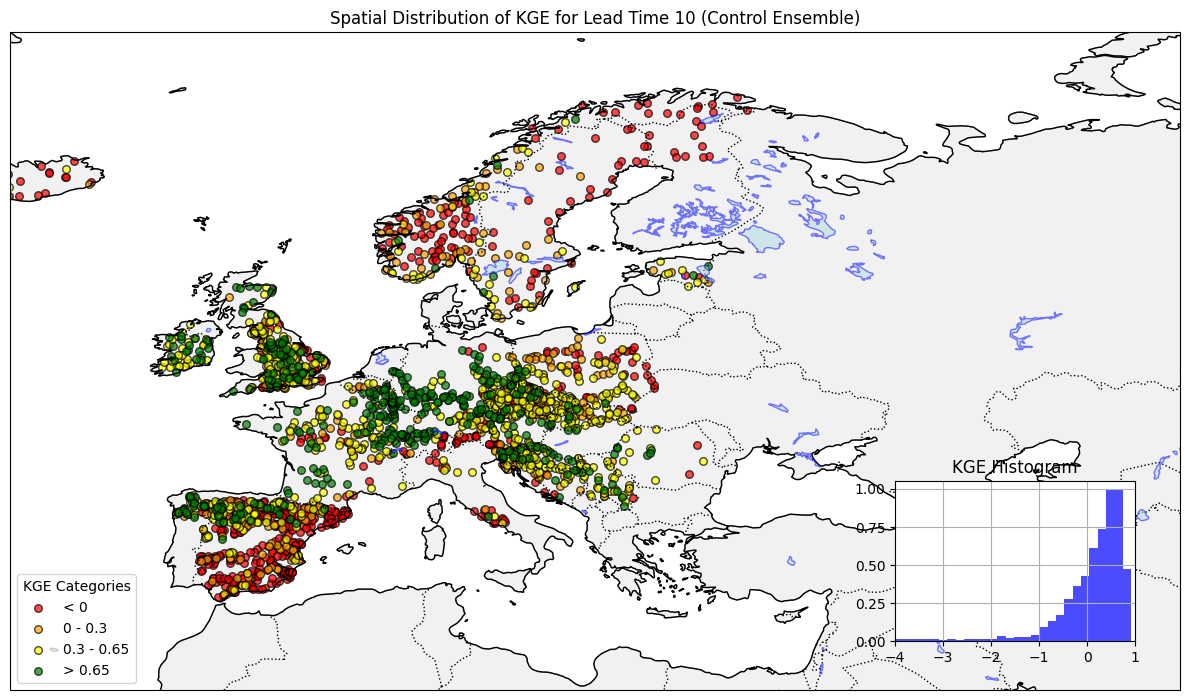

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
sns.reset_orig()
def plot_metric_spatial(metrics_dict, metric, station_info, lead_time, loaded_stations, filename):
    """
    Plots the specified metric from the control ensemble (ensemble 0) for all stations for a specific lead time.

    Parameters:
        metrics_dict (dict): Dictionary containing metrics (metric -> lead time -> ensemble -> station -> metric value).
        metric (str): The metric to plot (e.g., 'KGE').
        station_info (pd.DataFrame): DataFrame containing station metadata.
        lead_time (int): The lead time for which the metric is plotted.
        loaded_stations (dict): Mapping of station indices to station IDs.
        filename (str): File name to save the plot.
    """
    # Extract metric values for the specified lead time and control ensemble (ensemble 0)
    station_ids = []
    metric_values = []
    
    if metric in metrics_dict and lead_time in metrics_dict[metric] and 0 in metrics_dict[metric][lead_time]:
        for station_idx, station_id in loaded_stations.items():
            if station_idx < len(metrics_dict[metric][lead_time][0]):  # Ensure index is valid
                metric_value = metrics_dict[metric][lead_time][0][station_idx]
                
                if not np.isnan(metric_value):  # Ignore NaN values
                    station_ids.append(station_id)
                    metric_values.append(metric_value)

    # Create a DataFrame with the extracted data
    metric_df = pd.DataFrame({'station_id': station_ids, 'metric': metric_values})
    
    # Convert station_id to string for merging
    metric_df['station_id'] = metric_df['station_id'].astype(str)
    station_info['ObsID'] = station_info['ObsID'].astype(str)

    # Merge with station metadata
    merged_data = pd.merge(metric_df, station_info, how='left', left_on='station_id', right_on='ObsID')

    # Remove invalid metric values
    merged_data = merged_data.dropna(subset=['metric'])
    merged_data = merged_data[merged_data['metric'] >= -50]  # Remove extreme negative values

    # Define metric categories
    categories = [
        {'label': '< 0', 'condition': merged_data['metric'] < 0, 'color': 'red'},
        {'label': '0 - 0.3', 'condition': (merged_data['metric'] >= 0) & (merged_data['metric'] < 0.3), 'color': 'orange'},
        {'label': '0.3 - 0.65', 'condition': (merged_data['metric'] >= 0.3) & (merged_data['metric'] < 0.65), 'color': 'yellow'},
        {'label': '> 0.65', 'condition': merged_data['metric'] >= 0.65, 'color': 'green'}
    ]

    # Initialize the map
    fig = plt.figure(figsize=(12, 8))
    ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax_map.set_extent([-20, 60, 30, 75], crs=ccrs.PlateCarree())  # Europe-focused map

    # Add map features
    ax_map.add_feature(cfeature.BORDERS, linestyle=':')
    ax_map.add_feature(cfeature.COASTLINE)
    ax_map.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey', alpha=0.3)
    ax_map.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue', alpha=0.5)

    # Plot metric categories
    for category in categories:
        filtered_data = merged_data[category['condition']]
        ax_map.scatter(
            filtered_data['StationLon'], filtered_data['StationLat'],
            color=category['color'], label=category['label'], alpha=0.7, edgecolor='black', s=30
        )

    # Add legend and title
    ax_map.legend(title=f'{metric} Categories', loc='lower left')
    ax_map.set_title(f'Spatial Distribution of {metric} for Lead Time {lead_time} (Control Ensemble)')

    # Add a histogram subplot
    ax_hist = fig.add_axes([0.75, 0.15, 0.2, 0.2])  # [left, bottom, width, height]
    ax_hist.hist(merged_data['metric'].dropna(), bins=250, alpha=0.7, color='blue', density=True)
    ax_hist.set_xlim(-4, 1)
    ax_hist.set_title(f'{metric} Histogram')
    ax_hist.grid()

    # Save and display
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Example usage
station_info = pd.read_csv('/home/ecmv6565/Downloads/outlets_updated.csv')  # Load station metadata
lead_time = 10  # Choose desired lead time
metric_to_plot = 'KGE'
plot_metric_spatial(metrics_dict, metric_to_plot, station_info, lead_time, loaded_stations, 'metric_map.png')

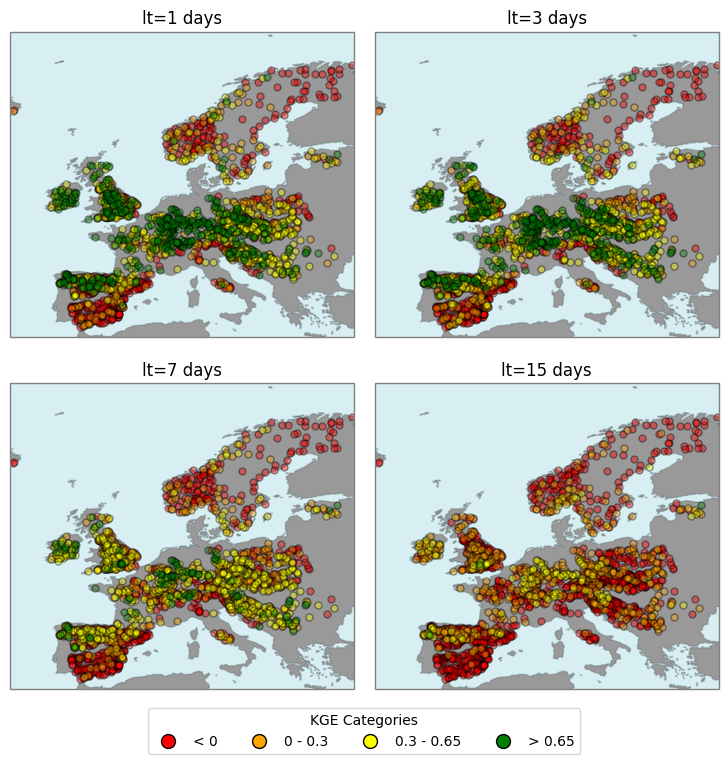

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

sns.reset_orig()

def plot_metric_spatial_multiple_lead_times(metrics_dict, metric, station_info, lead_times, loaded_stations, filename):
    """
    Plots the specified metric from the control ensemble (ensemble 0) for all stations for multiple lead times.

    Parameters:
        metrics_dict (dict): Dictionary containing metrics (metric -> lead time -> ensemble -> station -> metric value).
        metric (str): The metric to plot (e.g., 'KGE').
        station_info (pd.DataFrame): DataFrame containing station metadata.
        lead_times (list): List of lead times for which the metric is plotted.
        loaded_stations (dict): Mapping of station indices to station IDs.
        filename (str): File name to save the plot.
    """
    # Initialize the figure
    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    # Define metric categories
    categories = [
        {'label': '< 0', 'condition': lambda x: x < 0, 'color': 'red'},
        {'label': '0 - 0.3', 'condition': lambda x: (x >= 0) & (x < 0.3), 'color': 'orange'},
        {'label': '0.3 - 0.65', 'condition': lambda x: (x >= 0.3) & (x < 0.65), 'color': 'yellow'},
        {'label': '> 0.65', 'condition': lambda x: x >= 0.65, 'color': 'green'}
    ]

    for i, lead_time in enumerate(lead_times):
        ax = axes[i]
        ax.set_extent([-15, 30, 35, 75], crs=ccrs.PlateCarree())  # Europe-focused map

        # Add map features
        ax.add_feature(cfeature.LAND, edgecolor='gray', facecolor='gray', alpha=0.8)  # Land with gray fill
        ax.add_feature(cfeature.OCEAN, facecolor="#B0E0E6", alpha=0.5)  # Ocean with light blue fill

        # Add gray border around each subplot
        for spine in ax.spines.values():
            spine.set_edgecolor('gray')  # Set border color to gray
            spine.set_linewidth(1)     # Set border width

        # Extract metric values for the specified lead time and control ensemble (ensemble 0)
        station_ids = []
        metric_values = []

        if metric in metrics_dict and lead_time in metrics_dict[metric] and 0 in metrics_dict[metric][lead_time]:
            for station_idx, station_id in loaded_stations.items():
                if station_idx < len(metrics_dict[metric][lead_time][0]):  # Ensure index is valid
                    metric_value = metrics_dict[metric][lead_time][0][station_idx]
                    
                    if not np.isnan(metric_value):  # Ignore NaN values
                        station_ids.append(station_id)
                        metric_values.append(metric_value)

        # Create a DataFrame with the extracted data
        metric_df = pd.DataFrame({'station_id': station_ids, 'metric': metric_values})
        
        # Convert station_id to string for merging
        metric_df['station_id'] = metric_df['station_id'].astype(str)
        station_info['ObsID'] = station_info['ObsID'].astype(str)

        # Merge with station metadata
        merged_data = pd.merge(metric_df, station_info, how='left', left_on='station_id', right_on='ObsID')

        # Remove invalid metric values
        merged_data = merged_data.dropna(subset=['metric'])
        merged_data = merged_data[merged_data['metric'] >= -50]  # Remove extreme negative values

        # Plot metric categories
        for category in categories:
            filtered_data = merged_data[category['condition'](merged_data['metric'])]
            ax.scatter(
                filtered_data['StationLon'], filtered_data['StationLat'],
                color=category['color'], label=category['label'], alpha=0.4, edgecolor='black', s=25  # Scatter plot markers
            )

        ax.set_title(f'lt={int((lead_time + 1) / 4)} days', fontsize=12)

    # Add a shared legend at the bottom
    handles, labels = axes[0].get_legend_handles_labels()
    
    # Create custom legend handles with larger markers and no alpha
    custom_handles = []
    for handle, label in zip(handles, labels):
        custom_handle = plt.Line2D([], [], color=handle.get_facecolor()[0], marker='o', linestyle='None',
                                  markersize=10, markeredgecolor='black', alpha=1)  # Larger markers, no alpha
        custom_handles.append(custom_handle)

    fig.legend(custom_handles, labels, title=f'{metric} Categories', loc='lower center', bbox_to_anchor=(0.5, 0.06), ncol=4, fontsize=10)

    # Adjust layout and save
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15, wspace=-0.1, hspace=0.15)  # Adjust spacing
    plt.savefig(filename, bbox_inches='tight', dpi=300)  # High resolution for publication
    plt.show()

# Example usage
station_info = pd.read_csv('/home/ecmv6565/Downloads/outlets_updated.csv')  # Load station metadata
lead_times = [3, 11, 27, 59]  # Choose desired lead times
metric_to_plot = 'KGE'
plot_metric_spatial_multiple_lead_times(metrics_dict, metric_to_plot, station_info, lead_times, loaded_stations, 'metric_map_multiple_lead_times.png')

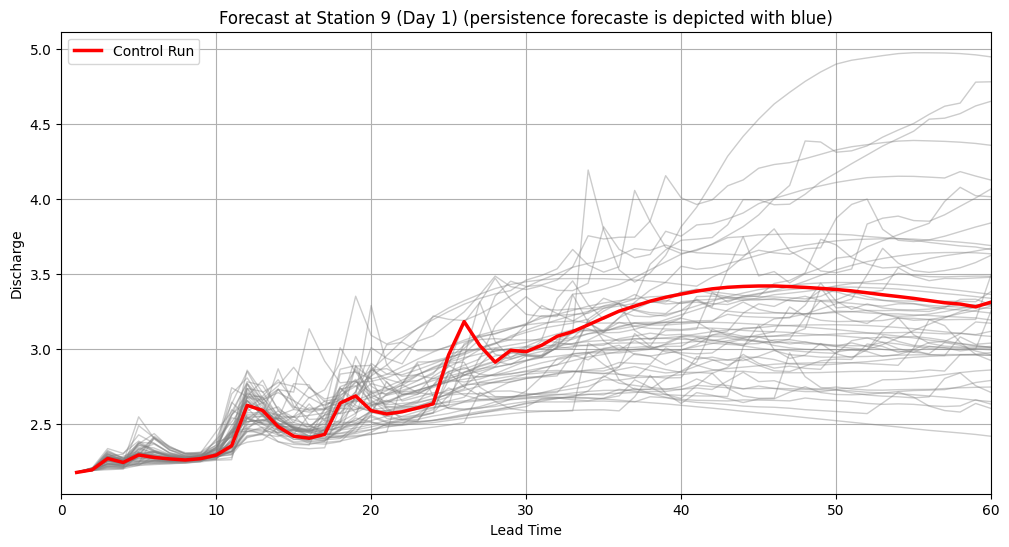

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Load discharge array (assuming it's already loaded as `loaded_discharge`)
#loaded_discharge = np.load('/ec/res4/hpcperm/ecmv6565/forecast_analysis/discharge_array.npy')

def plot_discharge(array, station_idx, day_idx):
    """
    Plot discharge for a selected station across lead times for all ensembles,
    with ensemble zero highlighted as the control run and persistence forecast.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot all other ensembles without labels
    for ensemble_idx in range(1, array.shape[1]):
        plt.plot(
            [ts+1 for ts in range(array.shape[2])],
            array[day_idx, ensemble_idx, :, station_idx],
            alpha=0.4,
            linewidth=1,
            color='gray',
            label='_nolegend_'  # Prevent these from appearing in the legend
        )
    
    # Plot ensemble zero (control run) last with its label in the legend
    plt.plot(
        [ts+1 for ts in range(array.shape[2])],
        array[day_idx, 0, :, station_idx],
        label="Control Run",
        color='red',
        linewidth=2.5,
        zorder=5
    )
    
    # Plot persistence forecast (constant discharge at initialization)
    persistence_value = array[day_idx, 0, 0, station_idx]  # Initial discharge value
    # plt.axhline(
    #     y=persistence_value,
    #     color='blue',
    #     linestyle='--',
    #     linewidth=2,
    #     label="Persistence Forecast",
    #     zorder=10
    # )
    
    plt.title(f"Forecast at Station {station_idx} (Day {day_idx + 1}) (persistence forecaste is depicted with blue)")
    plt.xlabel("Lead Time")
    plt.xlim(0,60)
    plt.ylabel("Discharge")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
selected_station = 9  # Change as needed (0 to 4241)
plot_discharge(loaded_discharge, station_idx=selected_station, day_idx=0)  # Day 1
#plot_discharge(loaded_discharge, station_idx=selected_station, day_idx=7)  # Day 2

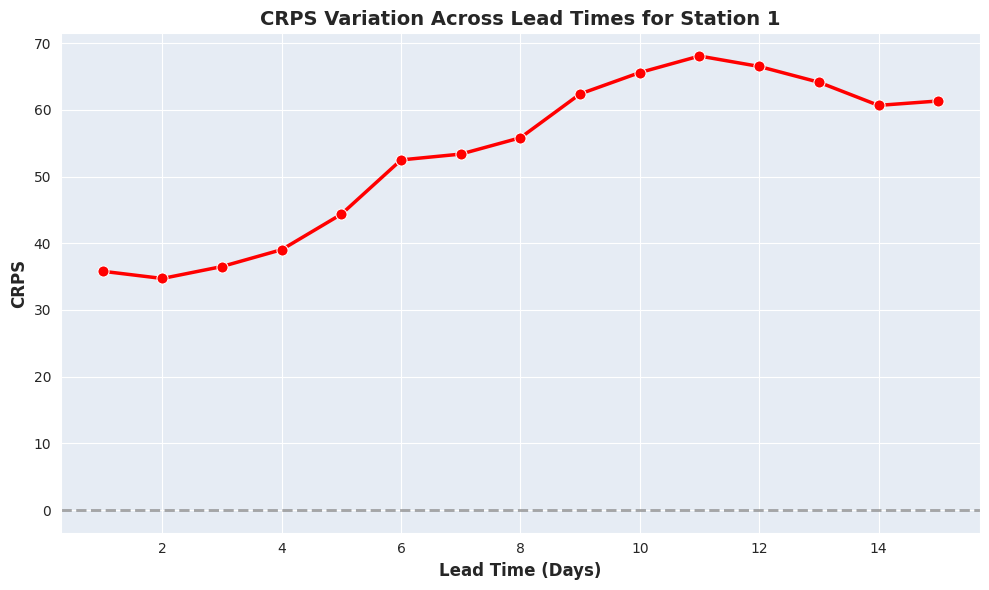

In [11]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the CRPS results
crps_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis_uncalibrated/crps_results.pkl"
with open(crps_path, "rb") as f:
    crps_dict = pickle.load(f)

# Convert CRPS results into a NumPy array for easy visualization
num_lead_times = len(crps_dict)
num_stations = len(next(iter(crps_dict.values())))  # Get number of stations from first lead time

# Store CRPS values in an array (lead_times × stations)
crps_array = np.full((num_lead_times, num_stations), np.nan)

for lead_time, station_values in crps_dict.items():
    for station, crps_value in station_values.items():
        crps_array[lead_time, station] = crps_value

# Define selected lead times in days (each day = 4 hourly time steps)
selected_days = list(range(1, 16))
selected_time_steps = [(day * 4 - 1) for day in selected_days]  # Convert to hourly lead times

# Convert the CRPS data into a pandas DataFrame for Seaborn compatibility
data = []
for lead_time, day in zip(selected_time_steps, selected_days):
    for station in range(num_stations):
        data.append([day, crps_array[lead_time, station], station + 1])

df = pd.DataFrame(data, columns=['Lead Time (Days)', 'CRPS', 'Station'])

# --- Choose a Specific Station ---
chosen_station = 1  # Replace with the station ID you want to plot
station_df = df[df['Station'] == chosen_station]

# --- Line Plot for the Chosen Station ---
sns.set_style("darkgrid")  # Darker grid style
background_color = "#E6ECF4"  # Light blue-gray background

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.set_facecolor(background_color)  # Set background color

# Line Plot for the Chosen Station
sns.lineplot(
    x="Lead Time (Days)", y="CRPS", data=station_df,
    color="red",  # Line color
    marker="o",  # Add markers for each data point
    markersize=8,  # Marker size
    linewidth=2.5  # Line width
)

# Title and Labels
plt.title(f"CRPS Variation Across Lead Times for Station {chosen_station}", fontsize=14, fontweight="bold")
plt.xlabel("Lead Time (Days)", fontsize=12, fontweight="bold")
plt.ylabel("CRPS", fontsize=12, fontweight="bold")

# Axis Limits
#plt.ylim(-10, 50)

# Add Key Reference Lines (Matching the KGE Plot)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=2, alpha=0.7)  # Subtle line at 0

# Adjust Tick Labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show Final Figure
plt.tight_layout()
plt.show()

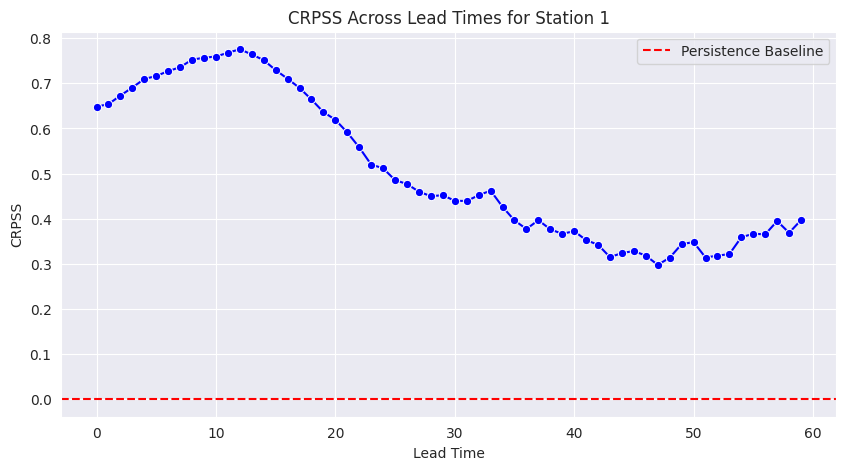

In [38]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CRPS results
# crps_forecast_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis/crps_results.pkl"
# crps_persistence_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis/crps_persistence_results.pkl"
crps_forecast_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis_uncalibrated/crps_results.pkl"
crps_persistence_path = "/ec/res4/hpcperm/ecmv6565/forecast_analysis_uncalibrated/crps_persistence_results.pkl"

with open(crps_forecast_path, "rb") as f:
    crps_forecast_dict = pickle.load(f)

with open(crps_persistence_path, "rb") as f:
    crps_persistence_dict = pickle.load(f)

# Choose a station (Replace this with the desired station index)
chosen_station = 1  # Change this to the station you want to analyze

# Compute CRPSS for the chosen station
lead_times = sorted(crps_forecast_dict.keys())
crpss_values = []

for lead_time in lead_times:
    crps_forecast = crps_forecast_dict[lead_time].get(chosen_station, np.nan)
    crps_persistence = crps_persistence_dict[lead_time].get(chosen_station, np.nan)
    
    if not np.isnan(crps_forecast) and not np.isnan(crps_persistence) and crps_persistence > 0:
        crpss = 1 - (crps_forecast / crps_persistence)
    else:
        crpss = np.nan

    crpss_values.append(crpss)

# Convert to DataFrame
df_crpss_station = pd.DataFrame({"Lead Time": lead_times, "CRPSS": crpss_values})

# 🔹 Plot CRPSS for the selected station
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_crpss_station, x="Lead Time", y="CRPSS", marker="o", color="b")
plt.axhline(0, color="red", linestyle="--", label="Persistence Baseline")  # Zero line
plt.xlabel("Lead Time")
plt.ylabel("CRPSS")
plt.title(f"CRPSS Across Lead Times for Station {chosen_station}")
plt.legend()
plt.grid(True)
plt.show()
